In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# true if overwriting saved file
save = True
# show all data files in dataset
path_list = []
for p in os.listdir("data"):
    path_list.append(os.path.join(os.getcwd(), "data", p))
for index, p in enumerate(path_list):
    print(f"[{index}]", p.split("\\")[-1])

[0] items.csv
[1] item_categories.csv
[2] sales_train.csv
[3] sample_submission.csv
[4] shops.csv
[5] test.csv


In [3]:
# load data
items = pd.read_csv(path_list[0])
item_ctgr = pd.read_csv(path_list[1])
train = pd.read_csv(path_list[2])
sample_submission = pd.read_csv(path_list[3])
shops = pd.read_csv(path_list[4])
test = pd.read_csv(path_list[5])

In [4]:
# display all datapoints in train and test
print("Train:")
for c in train.columns:
    print(f"Column: {c}, unique values: {len(train[c].unique())}")
print()
print("Test:")
for c in test.columns:
    print(f"Column: {c}, unique values: {len(test[c].unique())}")

Train:
Column: date, unique values: 1034
Column: date_block_num, unique values: 34
Column: shop_id, unique values: 60
Column: item_id, unique values: 21807
Column: item_price, unique values: 19993
Column: item_cnt_day, unique values: 198

Test:
Column: ID, unique values: 214200
Column: shop_id, unique values: 42
Column: item_id, unique values: 5100


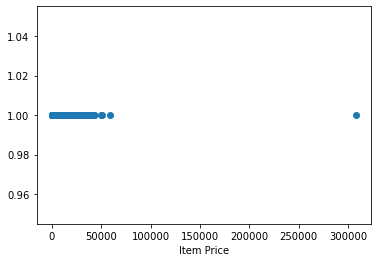

In [5]:
# plot price distribution
plt.scatter(x=train["item_price"], y=np.ones_like(train["item_price"]))
plt.xlabel("Item Price")
plt.show()

In [6]:
# drop outlier-items with price over 100k and items with negative price
train = train[(train["item_price"] < 100_000) & (train["item_price"] > 0)]

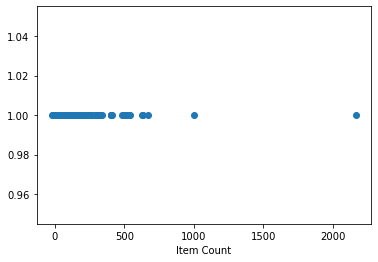

In [7]:
# plot sale count distribution
plt.scatter(x=train["item_cnt_day"], y=np.ones_like(train["item_cnt_day"]))
plt.xlabel("Item Count")
plt.show()

In [8]:
# drop outlier-items with sale count per day over 1k and items with negative salecounts
train = train[(train["item_cnt_day"] < 1_000) & (train["item_cnt_day"] > 0)]

In [9]:
# drop date column
train.drop("date", axis="columns", inplace=True)

In [10]:
import time
from itertools import product
from tqdm import tqdm
start = time.time()
# build matrix with all combinations of month, shop, and item
matrix = []

# loop over months and create item, shop combinations
for i in tqdm(range(len(train["date_block_num"].unique()))):
    month_sales = train[train["date_block_num"] == i]
    month_data = np.array(list(product(
    [i],
    month_sales["shop_id"].unique(),
    month_sales["item_id"].unique())), dtype = np.int16)
    matrix.append(month_data)
matrix = np.array(matrix, dtype=object)
print(f"Building Matrix took {int(time.time()-start)} seconds")

100%|██████████████████████████████████████████████████████████████████████████████████| 34/34 [00:12<00:00,  2.62it/s]

Building Matrix took 12 seconds


In [11]:
# format matrix into dataframe again and sort it
matrix = pd.DataFrame(np.vstack(matrix), columns=["date_block_num", "shop_id", "item_id"])
matrix.sort_values(["date_block_num", "shop_id", "item_id"], inplace = True)

In [12]:
# merge matrix and train to add datapoints
train = pd.merge(matrix, train, on=["date_block_num", "shop_id", "item_id"], how="inner")

In [13]:
# add item_cnt_day to train
item_prices = train.groupby(["item_id"])["item_price"].mean().round().reset_index()
train = train.groupby(["date_block_num", "shop_id", "item_id"])["item_cnt_day"].sum().reset_index()

In [14]:
# add item price
train = pd.merge(train, item_prices, on="item_id", how="left")
test = pd.merge(test, item_prices, on="item_id", how="left")

In [15]:
# add month of year as datapoint
train["month_of_year"] = ((train["date_block_num"] % 12) + 1)
test_month = (train["date_block_num"].max() % 12) + 2
test["month_of_year"] = test_month

In [16]:
# add item category from items df
train = pd.merge(train, items[["item_id", "item_category_id"]], on="item_id", how="left")
test = pd.merge(test, items[["item_id", "item_category_id"]], on="item_id", how="left")

In [17]:
# some items from the test dataset are new products since they are not in the train ds
# to still be able to make predictions about them them i will set their prices to the avg of the item category they are in
category_prices = train.groupby("item_category_id")["item_price"].mean().round().reset_index()
category_prices.set_index("item_category_id", inplace=True)
avg_prices_per_category = category_prices.loc[test["item_category_id"]].reset_index()["item_price"]
na_val_cnt = test["item_price"].isnull().sum()
print(f"{na_val_cnt} missing prices added")
test["item_price"].fillna(avg_prices_per_category, inplace=True)
test.set_index("ID", inplace=True)

15246 missing prices added


In [18]:
month_lag_count = 3
train_with_lag = train[train["date_block_num"] >= month_lag_count].copy()
sales_data = train[["date_block_num", "shop_id", "item_id", "item_cnt_day"]].copy()
test_lag_start = train["date_block_num"].max() - month_lag_count

for i in tqdm(range(1, month_lag_count+1)):
    month_num = month_lag_count + 1 - i
    
    # train data
    prev_col_name = "item_cnt_day" if i == 1 else f"prev_month_{month_num+1}"
    sales_data.rename(columns={prev_col_name: f"prev_month_{month_num}"}, inplace=True)
    sales_data["date_block_num"] += 1
    train_with_lag = train_with_lag.merge(sales_data, on=["date_block_num", "shop_id", "item_id"], how="left")
    
    # test data
    test_lag = train[train["date_block_num"] == test_lag_start][["shop_id", "item_id", "item_cnt_day"]].copy()
    test_lag.rename(columns={"item_cnt_day": f"prev_month_{month_num}"}, inplace=True)
    test = test.merge(test_lag, on=["shop_id", "item_id"], how="left")
    test_lag_start += 1
train_with_lag.fillna(0, inplace=True)
test.fillna(0, inplace=True)
if save:
    train_with_lag.to_csv("train_cleaned.csv", index=False)
    test.to_csv("test_cleaned.csv", index=False)

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.27it/s]
